In [4]:
# Import the function to get connect to the db
from snowexsql.db import get_db

# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@52.32.183.144/snowex'

# Using the function get_db, we receive 2 ways to interact with the database
engine, session = get_db(db_name)

These are the available columns in the table:
 
* date
* date_accessed
* doi
* easting
* elevation
* equipment
* geom
* instrument
* latitude
* longitude
* metadata
* northing
* site_id
* site_name
* surveyors
* time
* time_created
* time_updated
* type
* units
* utm_zone
* value
* version_number



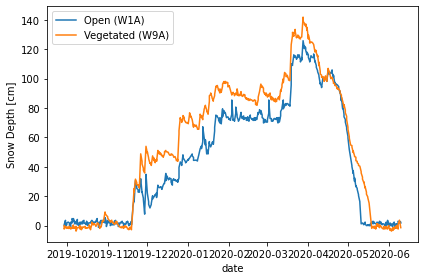

In [17]:
# Import the class reflecting the points table in the db
from snowexsql.data import PointData

# Import the function to investigate a table
from snowexsql.db import get_table_attributes

import snowexsql.db
from snowexsql.db import get_db
from snowexsql.data import PointData, SiteData
from snowexsql.conversions import query_to_geopandas

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

# Use the function to see what columns are available to use. 
db_columns = get_table_attributes(PointData)

# Print out the results nicely
print("These are the available columns in the table:\n \n* {}\n".format('\n* '.join(db_columns)))

# Grab the open site data from the db
open_site = 'W1A'
veg_site = 'W9A'
qry = session.query(PointData).filter(PointData.equipment.contains(open_site))
df_open = query_to_geopandas(qry,engine)

# Grab the vegetated site from the db
qry = session.query(PointData).filter(PointData.equipment.contains(veg_site))
df_veg = query_to_geopandas(qry,engine)

# Set the date as the index for easy plotting/reading
df_open2 = df_open.set_index('date')
df_veg2 = df_veg.set_index('date')

# Plot the 2 datasets by date!
ax = df_open2['value'].plot(label=f'Open ({open_site})')
df_veg2['value'].plot(ax=ax, label=f'Vegetated ({veg_site})')

# Mess with some labeling to make it look nice
ax.legend()
ax.set_ylabel('Snow Depth [cm]')
plt.tight_layout()
plt.show()

In [16]:
# Grab the open site data from the db
open_site = 'W1A'
veg_site = 'W9A'
qry = session.query(PointData).filter(PointData.equipment.contains(open_site))
df_open = query_to_geopandas(qry,engine)

# Grab the vegetated site from the db
qry = session.query(PointData).filter(PointData.equipment.contains(veg_site))
df_veg = query_to_geopandas(qry,engine)

# Set the date as the index for easy plotting/reading
#df_open = df_open.set_index('date')
#df_veg = df_veg.set_index('date')

In [18]:
from PIL import Image, ExifTags
import os
wd = os.getcwd()
print("Current WD: {}".format(wd))

Current WD: /home/jovyan/cam-learning/contributors/marianne


In [19]:
path_to_image = "/tmp/camera-trap/W9A/WSCT0660.JPG"


img = Image.open(path_to_image)
exif = { ExifTags.TAGS[k]: v for k, v in img._getexif().items() if k in ExifTags.TAGS }
keys = list(exif.keys())
print('\n*{}'.format('\n*'.join(keys)))


*GPSInfo
*PrintImageMatching
*ResolutionUnit
*ExifOffset
*ImageDescription
*Make
*Model
*Software
*Orientation
*DateTime
*YCbCrPositioning
*Copyright
*XResolution
*YResolution
*ExifVersion
*ComponentsConfiguration
*CompressedBitsPerPixel
*DateTimeOriginal
*DateTimeDigitized
*ShutterSpeedValue
*ApertureValue
*ExposureBiasValue
*MaxApertureValue
*MeteringMode
*LightSource
*Flash
*FocalLength
*ColorSpace
*ExifImageWidth
*SceneCaptureType
*ExifImageHeight
*Contrast
*Saturation
*Sharpness
*SensingMethod
*FileSource
*ExposureTime
*ExifInteroperabilityOffset
*FNumber
*SceneType
*ExposureProgram
*CustomRendered
*ISOSpeedRatings
*ExposureMode
*FlashPixVersion
*WhiteBalance
*DigitalZoomRatio
*CameraOwnerName
*BodySerialNumber
*FocalLengthIn35mmFilm
*LensSpecification
*LensMake
*LensModel
*LensSerialNumber
*MakerNote


Create a function to parse through all images. Save as dataframe with name of photo, date, and time. Then add SWE data by joining on dates+times. At that point we have images submit this to train.

In [20]:
from datetime import datetime
exif['DateTime'] = datetime.strptime(exif['DateTime'],'%Y:%m:%d %H:%M:%S')
print(exif['DateTime'])


2020-08-17 12:00:00


In [21]:
files = os.listdir('/tmp/camera-trap/W9A')
files =  ['/tmp/camera-trap/W9A/' + str(f) for f in files]


df = pd.DataFrame([],
                   columns=['date','photo_id','time','datetime','depth'])
for i in range(0,len(files)): 
    
    img = Image.open(files[i])
    exif = { ExifTags.TAGS[k]: v for k, v in img._getexif().items() if k in ExifTags.TAGS }
    exif['DateTime'] = datetime.strptime(exif['DateTime'],'%Y:%m:%d %H:%M:%S')
    df.loc[i]= [exif['DateTime'].date(),
                       files[i],
                       exif['DateTime'].time(),exif['DateTime'],'nan']

In [22]:
df_veg['datetime'] = [datetime.combine(df_veg['date'][i],df_veg['time'][i]).replace(tzinfo=None) for i in range(len(df_veg))]


In [23]:
from datetime import timedelta
from datetime import timezone

df_veg['datetime'][0].replace(tzinfo=None)


Timestamp('2019-10-11 11:00:00')

In [56]:
df_veg['datetime'][0].tzname
print(df['datetime'][0].tzinfo)

None


In [24]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input
from sklearn.model_selection import train_test_split
from PIL import Image
pixels = []
depth = []
i=0
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))
for i in range(len(df)):
    pivot = df['datetime'][i]
    items = df_veg['datetime']
    tmp = nearest(items,pivot)
    idx = np.where(items==tmp)[0][0]
    df['depth'][i] = df_veg['value'][idx]


<ipython-input-24-9a590565abb7>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['depth'][i] = df_veg['value'][idx]


In [25]:
df

,date,photo_id,time,datetime,depth
0,2019-11-19,/tmp/camera-trap/W9A/WSCT0116.JPG,12:00:00,2019-11-19 12:00:00,-2.78705
1,2019-10-22,/tmp/camera-trap/W9A/WSCT0060.JPG,12:00:00,2019-10-22 12:00:00,0.93423
2,2019-10-23,/tmp/camera-trap/W9A/WSCT0061.JPG,11:00:00,2019-10-23 11:00:00,0.00391
3,2019-10-21,/tmp/camera-trap/W9A/WSCT0057.JPG,11:00:00,2019-10-21 11:00:00,0.93423
4,2019-10-19,/tmp/camera-trap/W9A/WSCT0054.JPG,12:00:01,2019-10-19 12:00:01,-2.32189
...,...,...,...,...,...
651,2020-08-08,/tmp/camera-trap/W9A/WSCT0641.JPG,11:00:00,2020-08-08 11:00:00,-1.39157
652,2020-08-10,/tmp/camera-trap/W9A/WSCT0645.JPG,11:00:01,2020-08-10 11:00:01,-1.39157
653,2020-08-07,/tmp/camera-trap/W9A/WSCT0640.JPG,12:00:01,2020-08-07 12:00:01,-1.39157
654,2020-08-14,/tmp/camera-trap/W9A/WSCT0653.JPG,11:00:00,2020-08-14 11:00:00,-1.39157


In [26]:
for i in range(0, len(df)):
    # img = cv2.imread(str(path)+"/"+str(img))
    # src = Image.open(str(path)+"/"+str(img))
    path = df['photo_id'][i]
    src = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    #calculate the 50 percent of original dimensions
    width =200 # int(src.shape[1] * scale_percent / 100)
    height = 200 # int(src.shape[0] * scale_percent / 100)
    # dsize
    dsize = (width, height)
    # resize image
    output = cv2.resize(src, dsize)
    cv2.imwrite('tmp.jpg',output) 
    # img1 = img.save('tmp', format='JPEG',dpi=(50,50))
    img2 = cv2.imread('tmp.jpg')
    img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
    pixels.append(np.array(img2))

pixels = np.array(pixels)


In [29]:
pixels[1].shape
np.save('pixels.npy',pixels)
np.save('depths.npy',depths)

NameError: name 'depths' is not defined

In [30]:
depths = x = np.asarray(depths).astype('float32')
x_train,x_test,y_train,y_test = train_test_split(pixels,depths,random_state=100)


input = Input(shape=(200,200,3))
conv1 = Conv2D(140,(3,3),activation="relu")(input)
conv2 = Conv2D(130,(3,3),activation="relu")(conv1)
batch1 = BatchNormalization()(conv2)
pool3 = MaxPool2D((2,2))(batch1)
conv3 = Conv2D(120,(3,3),activation="relu")(pool3)
batch2 = BatchNormalization()(conv3)
pool4 = MaxPool2D((2,2))(batch2)
flt = Flatten()(pool4)
#age
age_l = Dense(128,activation="relu")(flt)
age_l = Dense(64,activation="relu")(age_l)
age_l = Dense(32,activation="relu")(age_l)
age_l = Dense(1,activation="relu")(age_l)


model = Model(inputs=input,outputs=[age_l])
model.compile(optimizer="adam",loss=["mse","sparse_categorical_crossentropy"],metrics=['mae','accuracy'])
save = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=3)
model.save("model.h5")

NameError: name 'depths' is not defined

In [81]:
depths = df['depth']

train_images = x_train
train_labels = y_train
test_images = x_test
test_labels = y_test

# Normalize the images.
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5

# Flatten the images.
train_images = train_images.reshape((-1, 59040000))
test_images = test_images.reshape((-1, 59040000))

print(train_images.shape) # (60000, 784)
print(test_images.shape)  # (10000, 784)

ValueError: cannot reshape array of size 19680000 into shape (59040000)

In [79]:
df['depth']

0     -2.78705
1      0.93423
2      0.00391
3      0.93423
4     -2.32189
        ...   
651   -1.39157
652   -1.39157
653   -1.39157
654   -1.39157
655   -1.39157
Name: depth, Length: 656, dtype: object